In [132]:
# Important libraries for the dashboard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

import plotly.express as px

from ipywidgets import interact, interactive, fixed, interact_manual, widgets, Dropdown
from IPython.display import display, HTML, Image, clear_output

In [134]:
from os import environ
# import md_token
# Pulling the data from MotherDuck
# cloud = duckdb.connect(f"md:clouddb?motherduck_token={md_token.MD_TOKEN}") 
cloud = duckdb.connect(f"md:clouddb?motherduck_token={environ['MD_TOKEN']}") 
data = cloud.query(f"SELECT * FROM 'clouddb.main.df2'").df()

# cloud.execute("LOAD motherduck")
# cloud.sql("SHOW DATABASES").show()

InvalidInputException: Invalid Input Error: Attempting to execute an unsuccessful or closed pending query result
Error: Invalid Error: RPC 'SETUP_PLAN_FRAGMENTS' failed: recvmsg:Operation timed out (UNAVAILABLE, request id: 'db3d3ad7-0980-4b28-bd9d-6bf78be92bdc')

## Dashboard (part of Magicalytics project)
This dashboard sample is just to test the whole pipeline and MVP for deploying the Voila dashboard online.
The pipeline is focusing on the Extract, Transform, and Load (ETL) process.
Analytics data is acquired from BigQuery and after some filtering, the data is pushed into MotherDuck data warehouse. This dashboard then receive the data from the cloud and visualize what is necessary.

To visualize the workflow, the figure below provides how the data is ingested, cleaned, and pushed into data warehouse for production ready.

In [135]:
Image(url= "https://drive.google.com/uc?export=view&id=1JFyUs_UO5Wv6LHQ1J4n8Ry-Lwslvc3nM")
# Image(filename='/Users/immanuelsanka/Desktop/Medium/magicalytics/images/ETL_diagram.png') 

In [136]:
# Making the query into dataframe
# Imputation using mode value for score column
mode_value = data['score'].mode()[0]
data['score'].fillna(mode_value, inplace=True)
print("Is there any missing data?")
data.isna().sum()

Is there any missing data?


refresh_date     0
region_name      0
score            0
term             0
rank             0
group_in_rank    0
percent_gain     0
year             0
month            0
day              0
dtype: int64

In [137]:
# Making the datetime into the correct format
data['refresh_date'] = pd.to_datetime(data['refresh_date'])
data['year'] = data['refresh_date'].dt.year
data['month'] = data['refresh_date'].dt.month
data['day'] = data['refresh_date'].dt.day

Data distribution accross specific regions and months


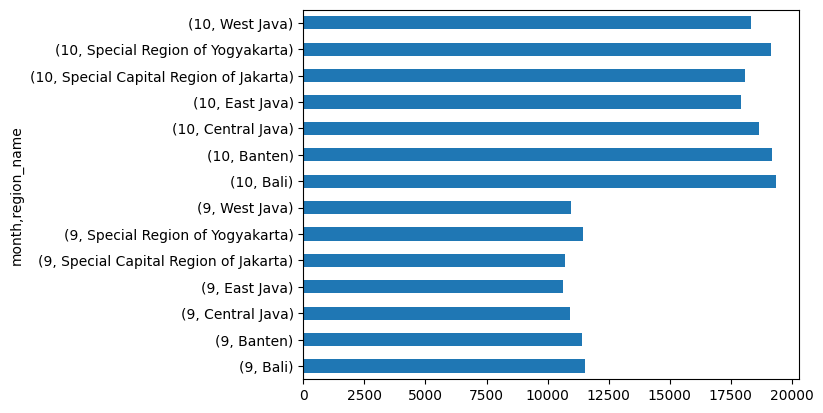

In [138]:
print("Data distribution accross specific regions and months")
data.groupby(['month','region_name']).size().plot(kind='barh');

In [139]:
# Now we want to see how each term behave in two months across different regions in Java-Bali
top10_data = data.groupby('term').size().reset_index(name='Count').sort_values(by='Count', ascending=False).head(10).sort_values(by='Count')#.plot(x='term',y='Count',kind='barh')
top10 = top10_data.term.values.tolist()
filtered_data = data[data['term'].isin(top10)]
overall_grouped = filtered_data.groupby(['refresh_date', 'term'], as_index=False).agg({'score': 'count'})

# print(overall_grouped.head(5))
# sns.lineplot(x='refresh_date',y='score', hue='term', data=overall_grouped)
# filtered_data

In [28]:
overall_grouped = filtered_data.groupby(['refresh_date', 'term', 'region_name'], as_index=False).agg({'score': 'count'})

regions = filtered_data['region_name'].unique().tolist()

# Create a dropdown widget for regions
region_dropdown = widgets.Dropdown(
    options=regions,
    description='Region:',
    disabled=False,
)

output = widgets.Output()  # Create an Output widget to manage display

def plot_for_region(region):
    with output:
        # Filter data for the selected region
        region_data = overall_grouped[overall_grouped['region_name'] == region]

        # Plot
        fig, ax = plt.subplots(figsize=(15, 4))
        for term in top10:
            subset = region_data[region_data['term'] == term]
            ax.plot(subset['refresh_date'], subset['score'], label=term)

        ax.set_xlabel('Refresh Date')
        ax.set_ylabel('Score')
        ax.set_title(f'Terms across different dates in {region} over two months')
        ax.legend(loc='upper left')
        ax.grid(True)

        plt.tight_layout()
        plt.show()

def on_region_change(change):
    output.clear_output(wait=True)  # Clear previous outputs
    plot_for_region(change['new'])

region_dropdown.observe(on_region_change, names='value')

# Initial display
display(region_dropdown)
plot_for_region(regions[0])
display(output)  # Display the Output widget

Dropdown(description='Region:', options=('East Java', 'Special Capital Region of Jakarta', 'Banten', 'Special …

Output()

In [ ]:
# print("Terms accross different dates")
# sns.lineplot(x='refresh_date',y='score', hue='term', data=overall_grouped)

In [142]:
# # Create a variable for the threshold selection
# threshold = widgets.IntSlider(
#     min=0, max=1000, step=100, value=0,
#     description='Threshold:',
#     disabled=False,
# )

In [ ]:
# def plot_overall():
#     # Group by 'refresh_date' and 'term', then count 'score'
#     overall_grouped = filtered_data.groupby(['refresh_date', 'term'], as_index=False).agg({'score': 'count'})

#     # Create a line plot
#     fig = px.line(overall_grouped, 
#                   x='refresh_date', 
#                   y='score', 
#                   color='term',
#                   title='Overall Term Scores Over Time',
#                   labels={'score': 'Total Score'},
#                   )
#     fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=False)
#     fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=False)

#     fig.update_layout({
#         'width': 800, # specify your width
#         'height': 600, # specify your height
#         'plot_bgcolor': 'white',
#         'paper_bgcolor': 'white',
        
#     })
#     fig.show()

# plot_overall()

In [141]:
# import bqplot as bq

# grouped = filtered_data.groupby(['refresh_date', 'term','region_name'], as_index=False).agg({'score': 'count'})

# x_sc = bq.DateScale()
# y_sc = bq.LinearScale()

# ax_x = bq.Axis(scale=x_sc, label='Refresh Date', grid_lines='solid')
# ax_y = bq.Axis(scale=y_sc, orientation='vertical', label='Total Score', grid_lines='solid')

# lines = bq.Lines(x=[], y=[], scales={'x': x_sc, 'y': y_sc}, colors=bq.CATEGORY10)

# fig = bq.Figure(axes=[ax_x, ax_y], marks=[lines], layout={'min_width': '800px', 'min_height': '600px'}, background_style={'fill': 'white'})

# def update_line(region):
#     filtered_df = grouped[grouped['region_name'] == region]
#     terms = filtered_df['term'].unique()
    
#     lines.x = [filtered_df[filtered_df['term'] == term]['refresh_date'].values for term in terms]
#     lines.y = [filtered_df[filtered_df['term'] == term]['score'].values for term in terms]
#     lines.labels = list(terms)
#     lines.display_legend = True

# region_dropdown = Dropdown(options=grouped['region_name'].unique(), description='Region:')
# interact(update_line, region=region_dropdown);

# fig